<a href="https://colab.research.google.com/github/hyun3282/web1/blob/main/AirPassengerForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [470]:
#import tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


In [471]:
from google.colab import drive
# Please mount your drive.
drive.mount('/content/drive')
Passenger_data=pd.read_csv('/content/drive/MyDrive/Time_Series_HW/AirPassengers.csv',index_col=0)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [472]:
Passenger_data.index.name = 'date'
Passenger_data.columns = ['Passenger_num']

num = Passenger_data['Passenger_num']
num.index = pd.to_datetime(num.index)
num.index.freq = 'MS'

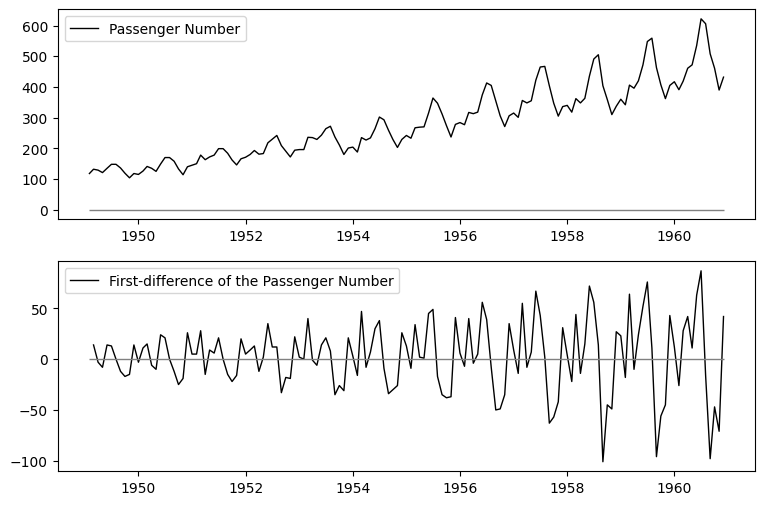

In [473]:

f, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 2*3))
axes[0].plot(num,color='black',linewidth=1,label='Passenger Number')
axes[0].hlines(xmin=num.index[0],xmax=num.index[-1],y=0,color='gray',linewidth=1)
axes[0].legend()
axes[1].plot(num.diff(),color='black',linewidth=1,label='First-difference of the Passenger Number')
axes[1].hlines(xmin=num.index[0],xmax=num.index[-1],y=0,color='gray',linewidth=1)
axes[1].legend()

plt.show()


# ADF test

In [474]:
def adf_test(dataframe):
  result = adfuller(dataframe)
  print(f'Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Critical values: {result[4]}')
adf_test(num)
print('---'*40)
adf_test(num.diff().dropna())


Statistics: 0.7923399959692623
p-value: 0.991511509628866
Critical values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}
------------------------------------------------------------------------------------------------------------------------
Statistics: -2.83342564556533
p-value: 0.053655499158908174
Critical values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}


#KPSS 테스트


In [475]:
def kpss_test(dataframe):
  result = kpss(dataframe)
  print(f'Statistics: {result[0]}')
  print(f'bounded p-value: {result[1]}')
  print(f'Critical values: {result[3]}')
kpss_test(num)
print('---'*40)
kpss_test(num.diff().dropna())

Statistics: 1.638609802673602
bounded p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.02419382862398609
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


#ACF&PACF


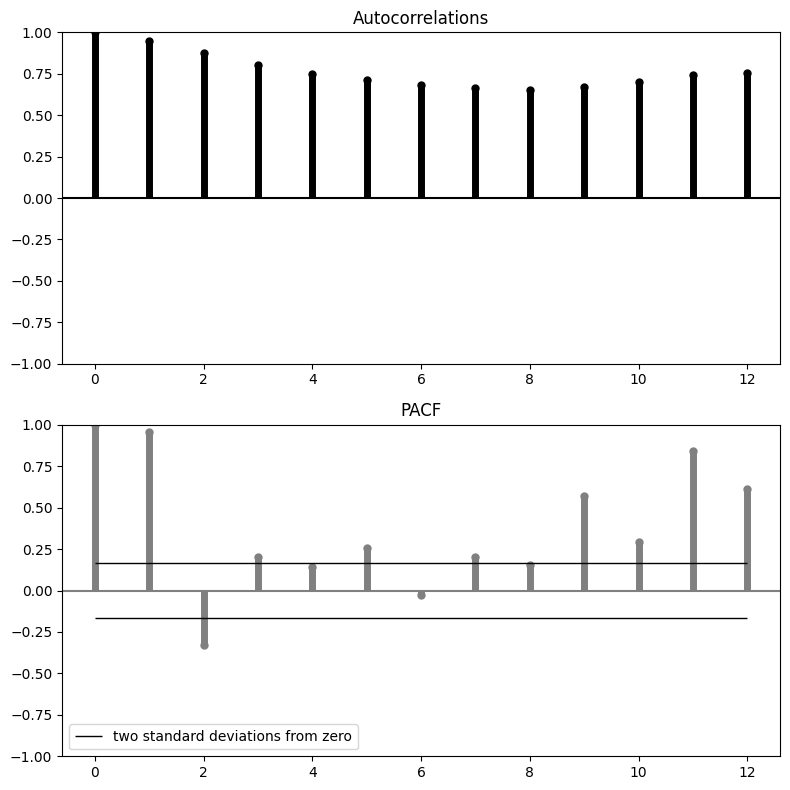

In [476]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(num, lags=12, ax=axes[0], title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(num, lags=12, ax=axes[1], method='ols', title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[1].hlines(xmin=0,xmax=12,y=2*np.sqrt(1/len(num)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=12,y=-2*np.sqrt(1/len(num)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()


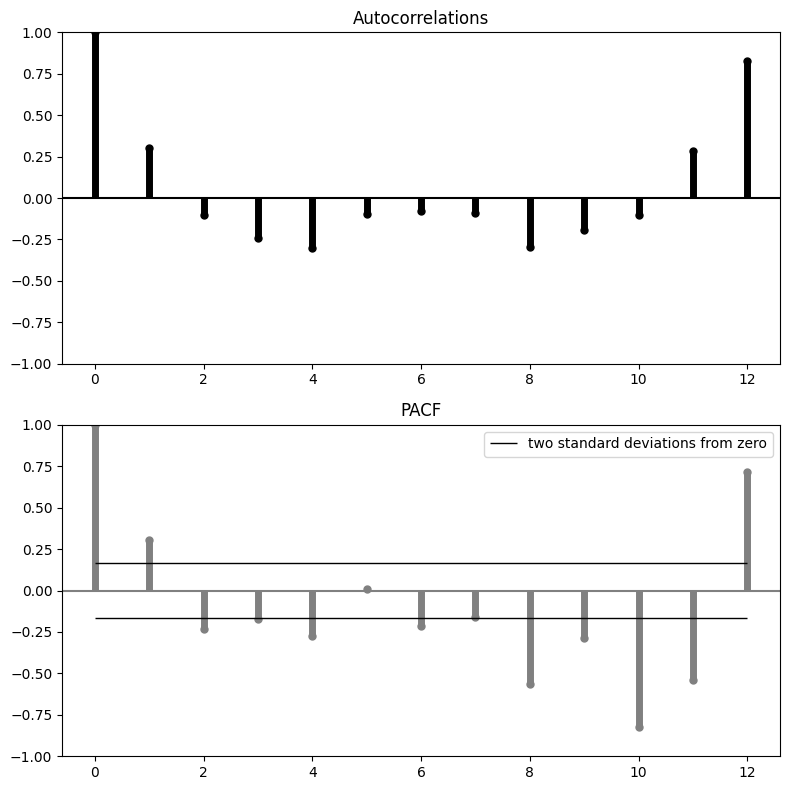

In [477]:
differenced_num=num.diff()
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(differenced_num.dropna(), lags=12, ax=axes[0], title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(differenced_num.dropna(), lags=12, ax=axes[1], method='ols', title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[1].hlines(xmin=0,xmax=12,y=2*np.sqrt(1/len(differenced_num)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=12,y=-2*np.sqrt(1/len(differenced_num)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()



In [478]:
 #Define a function to get the maximum value(s) from an element in the set
def get_max_value(element):
  if isinstance(element, int) or isinstance(element, float):
    return element
  else:
    return max(element)


In [479]:
lag_list = [ (5, 1, 0),(list(range(1,7)),1,0),([1,2],1,0),(2,1,1),(2,1,[1,5])]

# ARIMA(5,1,0),arima(6,1,0),arima(2,1,0),arima(2,1,1),arima(2,1,[1,5])
# We will estimate 5 different models.
summary_table = dict()
idx=0
num_of_obs = len(num[6:])
for lag in lag_list:
  # SSE i.e SSR, AIC, SBC, Ljung–Box Q-statistics of the residual autocorrelations for lag:={4, 8, 12}.
  temp_perf_dict = {key: key for key in ['SSE','AIC','SBC','Q(4)','Q(8)','Q(12)']}
  # Get the maximum value(s) from each element in the set
  max_values = [get_max_value(elem) for elem in lag]
  max_element = max(max_values)
  # We use num[6-max_element:] to estimate each equation
  res = ARIMA(endog =num[(6-max_element):], order=lag, trend='n'). fit(method='statespace') # Use Durbin–Levinson algorithm. You can also use other estimation method.
  temp_perf_dict['SSE'] = round(res.sse,2)
  # Note that since we assume the model errors are IID according to a normal distribution, the BIC and AIC formula is bit different from a general form.
  temp_perf_dict['AIC'] = round(num_of_obs*np.log(res.sse) + 2*len(res.params),2)
  temp_perf_dict['SBC'] = round(num_of_obs*np.log(res.sse) + len(res.params)*np.log(num_of_obs),2)
  # Lijung-box Q-statistics for lag 4,8,12
  q_statistics = res.test_serial_correlation(method='ljungbox',lags=12)[0]
  temp_perf_dict['Q(4)'] = {'q_stats' : round(q_statistics[0][3],2), 'p_val': round(q_statistics[1][3],2)}
  temp_perf_dict['Q(8)'] = {'q_stats' : round(q_statistics[0][7],2), 'p_val': round(q_statistics[1][7],2)}
  temp_perf_dict['Q(12)'] = {'q_stats' : round(q_statistics[0][11],2), 'p_val': round(q_statistics[1][11],2)}
  for param_name, param in zip(res.params.index, res.params):
    temp_perf_dict[param_name] = {'coef':round(param,2), 't_stats':round(res.tvalues[param_name],2)}
  hashable_order = tuple([tuple(order) if isinstance(order,list) == True else order for order in res.specification['order']]) # make res.specification['order'] hashable.
  summary_table[hashable_order] = temp_perf_dict


In [480]:
table_2_4 = pd.DataFrame()
for key, value in summary_table.items():
  temp_series = pd.Series(value, name=key)
  table_2_4 = pd.concat([table_2_4,temp_series],axis=1)

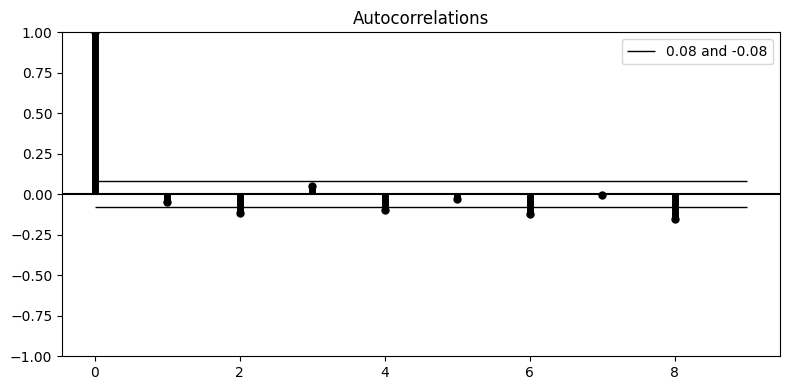

In [481]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
# the ACF of the last model's residuals.
plot_acf(res.resid, lags=8, ax=axes, title='Autocorrelations',color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
axes.hlines(xmin=0,xmax=9,y=0.08,label='0.08 and -0.08',color='black',linewidth=1)
axes.hlines(xmin=0,xmax=9,y=-0.08,color='black',linewidth=1)
axes.legend()
plt.tight_layout()
plt.show()

In [482]:
table_2_4.loc[['ar.L1','ar.L2','ar.L3','ar.L4','ar.L5','ma.L1','ma.L5','SSE','AIC','SBC','Q(4)','Q(8)','Q(12)'],:] # For ordering the row of the table.

,"(5, 1, 0)","(6, 1, 0)","(2, 1, 0)","(2, 1, 1)","(2, 1, (1, 5))"
ar.L1,"{'coef': 0.32, 't_stats': 3.28}","{'coef': 0.32, 't_stats': 3.02}","{'coef': 0.38, 't_stats': 4.21}","{'coef': 1.09, 't_stats': 12.79}","{'coef': 1.23, 't_stats': 12.02}"
ar.L2,"{'coef': -0.22, 't_stats': -2.72}","{'coef': -0.26, 't_stats': -3.26}","{'coef': -0.23, 't_stats': -3.38}","{'coef': -0.49, 't_stats': -4.88}","{'coef': -0.44, 't_stats': -5.26}"
ar.L3,"{'coef': -0.07, 't_stats': -0.93}","{'coef': -0.07, 't_stats': -1.04}",NaN,NaN,NaN
ar.L4,"{'coef': -0.27, 't_stats': -3.5}","{'coef': -0.3, 't_stats': -4.07}",NaN,NaN,NaN
ar.L5,"{'coef': 0.02, 't_stats': 0.26}","{'coef': 0.08, 't_stats': 0.71}",NaN,NaN,NaN
ma.L1,NaN,NaN,NaN,"{'coef': -0.84, 't_stats': -11.13}","{'coef': -1.18, 't_stats': -8.12}"
ma.L5,NaN,NaN,NaN,NaN,"{'coef': 0.28, 't_stats': 1.61}"
SSE,144935.62,137508.74,157662.4,138646.48,118188.35
AIC,1640.11,1634.91,1645.64,1630.04,1610.16
SBC,1657.63,1655.35,1654.4,1641.72,1624.76


#예측 수행

In [483]:
# out-of-sample prediction with expanding rolling window.
checker = num.index <= '1958-12-01'
train_set = num[checker]
test_set = num[~checker]
n_train = len(train_set)
n_test = len(test_set)
f1, f1_error = [], []
f2, f2_error = [], []
ground_truth = []
for i in range(n_test):
  crt_time = i + n_train
  x_train = num[:crt_time]
  # iterate over the time series data, fitting the model on each expanding window of data
  model_1 = ARIMA(endog = x_train, order=(5,1,0), trend='n').fit(method='statespace') # model 1
  model_2 = ARIMA(endog = x_train, order=(2,1,[1,5]), trend='n').fit(method='statespace') # model 2
  # one-step-ahead forecasts
  forecast_1 = model_1.forecast(steps=1)
  forecast_2 = model_2.forecast(steps=1)
  # true one-step-ahead value
  y = num[crt_time]
  ground_truth.append(y)
  f1.append(forecast_1[0])
  f1_error.append(y-forecast_1[0])
  f2.append(forecast_2[0])
  f2_error.append(y-forecast_2[0])

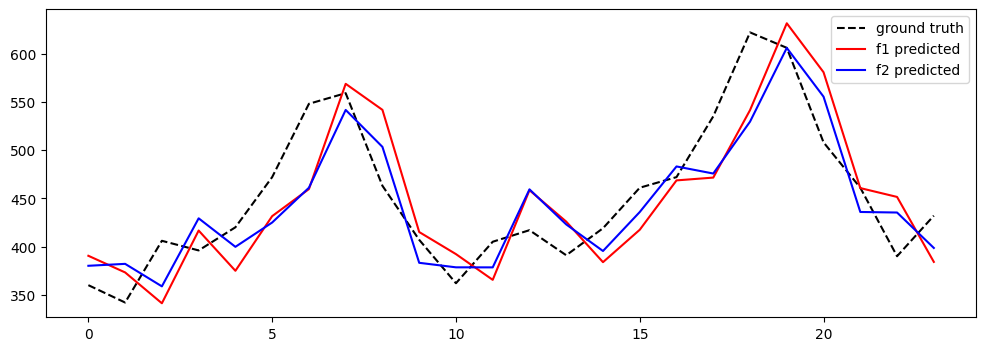

In [484]:
# plot the results
plt.figure(figsize=(12,4))
plt.plot(ground_truth, label='ground truth', color='k', linestyle='--')
plt.plot(f1, label='f1 predicted', color='r')
plt.plot(f2, label='f2 predicted', color='b')
plt.legend()
plt.show()

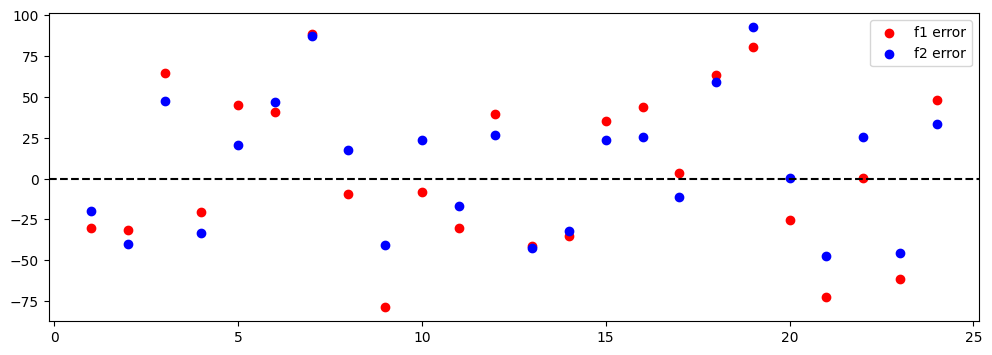

In [485]:
# plot the results
plt.figure(figsize=(12,4))
plt.scatter(np.linspace(1,len(f1_error),len(f1_error)), f1_error, label='f1 error', color='r')
plt.scatter(np.linspace(1,len(f2_error),len(f2_error)), f2_error, label='f2 error', color='b')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.show()

In [486]:
s_1959_01 = ground_truth[0] #
f1_1959_01 = f1[0]
f2_1959_01 = f2[0]
f1 = pd.Series(f1)
f2 = pd.Series(f2)
f1_error = pd.Series(f1_error)
f2_error = pd.Series(f2_error)
print(f"Actual value:{round(s_1959_01,3)}, f1 forecast:{round(f1_1959_01,3)},f2 forecast:{round(f2_1959_01,3)}")
print(f"avg f1:{round(np.array(f1).mean(),4)}, avg f2:{round(np.array(f2).mean(),4)}")
print(f"var of f1:{round(np.array(f1).var(),4)}, var of f2:{round(np.array(f2).var(),4)}")
print(f'mean squared prediction error of f1: {round((f1_error**2).mean(),4)}, mean squared prediction error of f2: {round((f2_error**2).mean(),4)}')


Actual value:360, f1 forecast:390.451,f2 forecast:380.09
avg f1:447.7561, avg f2:443.9057
var of f1:5510.9623, var of f2:4046.5567
mean squared prediction error of f1: 2310.0062, mean squared prediction error of f2: 1719.1953


In [487]:
# Joint f-test for model 1
dta = pd.concat([pd.Series(f1,name='f1'), pd.Series(ground_truth,name='s')],axis=1)
dta.columns=['f1','s']
formula = 's ~ f1'
results = sm.OLS.from_formula(formula = formula, data = dta).fit()
hypotheses = '(Intercept = 0), (f1 = 1)'
f_test = results.f_test(hypotheses)
print(f_test)
print(results.params)

<F test: F=1.3026451479214347, p=0.29196854343002016, df_denom=22, df_num=2>
Intercept    94.845439
f1            0.798213
dtype: float64


In [488]:
# Joint f-test for model 2
dta = pd.concat([pd.Series(f2,name='f2'), pd.Series(ground_truth,name='s')],axis=1)
dta.columns=['f2','s']
formula = 's ~ f2'
results = sm.OLS.from_formula(formula = formula, data = dta).fit()
hypotheses = '(Intercept = 0), (f2 = 1)'
f_test = results.f_test(hypotheses)
print(f_test)
print(results.params)


<F test: F=0.47043241191764007, p=0.6308728595447538, df_denom=22, df_num=2>
Intercept    14.895406
f2            0.985242
dtype: float64


In [489]:
x_i = f1_error + f2_error
z_i = f1_error - f2_error
corr_xz = x_i.corr(z_i,method='pearson')
Granger_Newbold_stats = corr_xz/ np.sqrt( (1-corr_xz**2)/24 )
print(Granger_Newbold_stats)

2.1986854573276453


In [490]:
d = np.power(f1_error, 4) - np.power(f2_error, 4)
DM = np.mean(d) / np.power(np.var(d) / (len(d) - 1), 0.5)
print(DM)
acf_d = acf(d, nlags=12)[1:]
print(acf_d)


1.242152481754534
[-0.12125568 -0.1373748  -0.03235505 -0.08356212 -0.04785028  0.12306041
 -0.04579446 -0.05389338  0.05244292 -0.40905033 -0.01117737  0.21209333]


#seasonal

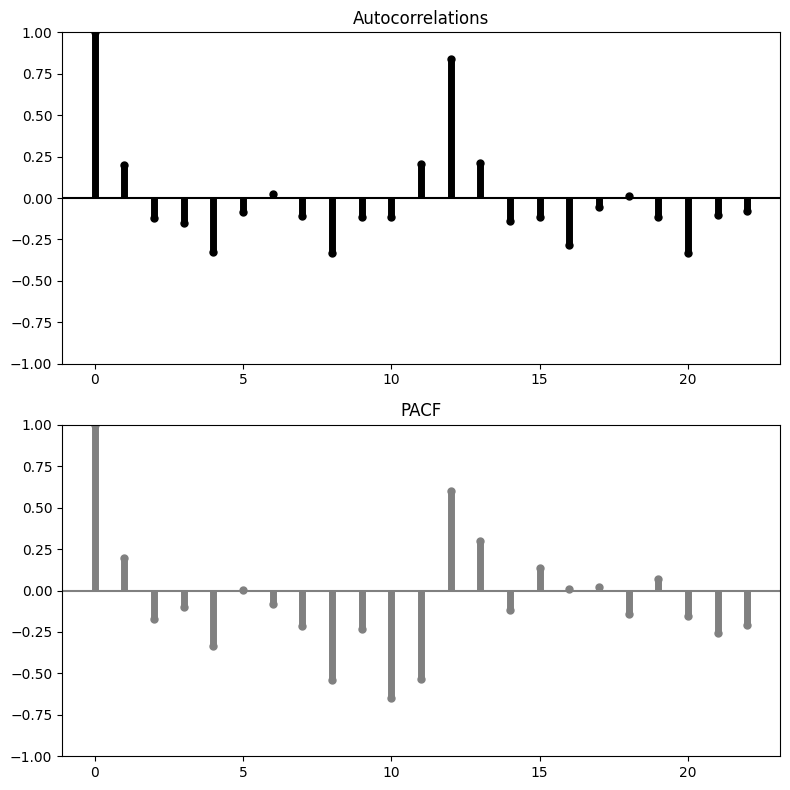

In [491]:
#log differenced
num_log_differenced = np.log(num/num.shift(1))
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(num_log_differenced.dropna(), lags=22, ax=axes[0],title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(num_log_differenced.dropna(), lags=22, ax=axes[1], method='ols',title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5},alpha=None)
plt.tight_layout()
plt.show()


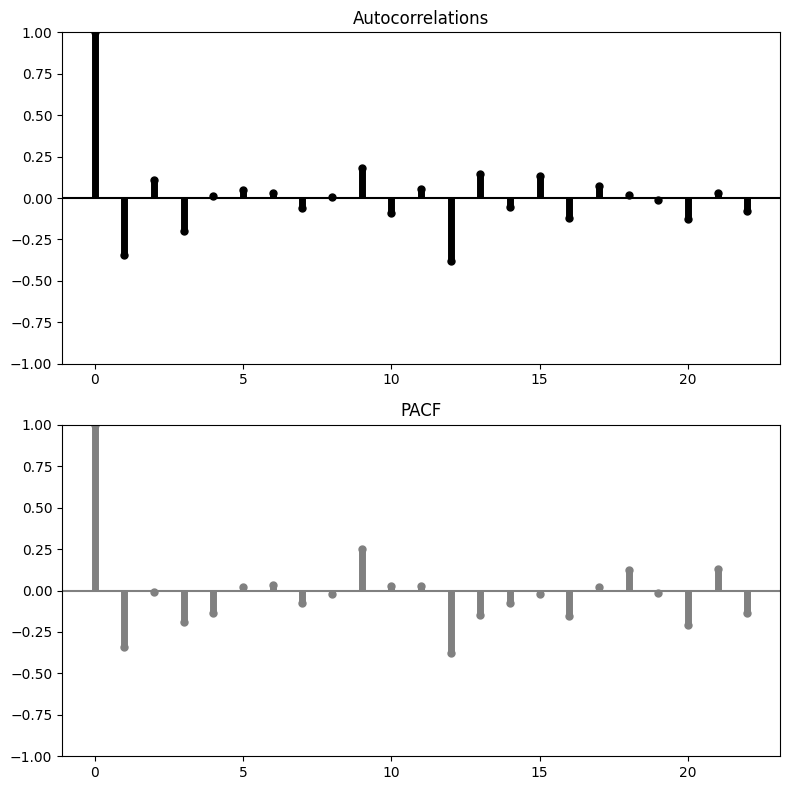

In [492]:
num_seasonal_difference = np.log(num/num.shift(12)).diff().dropna()
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(num_seasonal_difference, lags=22, ax=axes[0], title='Autocorrelations',color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(num_seasonal_difference, lags=22, ax=axes[1], method='ols',title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5},alpha=None)
plt.tight_layout()
plt.show()


In [493]:
print('ADF')
adf_test(num_seasonal_difference)
print('---'*40)
print('KPSS')
kpss_test(num_seasonal_difference)


ADF
Statistics: -4.549180148695245
p-value: 0.00016009049261959363
Critical values: {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}
------------------------------------------------------------------------------------------------------------------------
KPSS
Statistics: 0.05110206356609082
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [494]:
# model_1: AR(2) with Seasonal AR term with lag 12
# model_2: Multiplicative Autoregressive
# model_3: Multiplicative Moving Average
# model_4: Multiplicative Autoregressive in seasonal, and moving average
model_1 = sm.tsa.statespace.SARIMAX(num_seasonal_difference, trend='c',order=(2, 0,(0,0,0,0,0,0,0,0,0,0,0,1))).fit()
model_2 = sm.tsa.statespace.SARIMAX(num_seasonal_difference, trend='c',order=(2, 0, 0), seasonal_order=(1,0,0,12)).fit()
model_3 = sm.tsa.statespace.SARIMAX(num_seasonal_difference, trend='c',order=(0, 0, 1), seasonal_order=(0,0,1,12)).fit()
model_4 = sm.tsa.statespace.SARIMAX(num_seasonal_difference, trend='c',order=(0, 0, 1), seasonal_order=(1,0,0,12)).fit()
summary_table = dict()
idx=0
for model in [model_1, model_2, model_3,model_4]:
  res = model
  # SSE i.e SSR, AIC, SBC, Ljung–Box Q-statistics of the residual autocorrelations for lag:={4, 8, 12}.
  temp_perf_dict = {key: key for key in['SSE','AIC','SBC','Q(4)','Q(8)','Q(12)']}
  # Get the maximum value(s) from each element in the set
  max_values = [get_max_value(elem) for elem in lag]
  max_element = max(max_values)
  # We use spread[7-max_element:] to estimate each equation over the 1961Q4-2012Q4.
  temp_perf_dict['SSE'] = round(res.sse,3)
  # Note that since we assume the model errors are IID according to a normal distribution, the BIC and AIC formula is bit different from a general form.
  temp_perf_dict['AIC'] = round(num_of_obs*np.log(res.sse) + 2*len(res.params),3)
  temp_perf_dict['SBC'] = round(num_of_obs*np.log(res.sse) + len(res.params)*np.log(num_of_obs),3)
  # Lijung-box Q-statistics for lag 4,8,12
  q_statistics = res.test_serial_correlation(method='ljungbox',lags=12)[0] #*** Do we have to adjust chi-squared distribution with the degree of freedom? ***
  temp_perf_dict['Q(4)'] = {'q_stats' : round(q_statistics[0][3],2), 'p_val':round(q_statistics[1][3],3)}
  temp_perf_dict['Q(8)'] = {'q_stats' : round(q_statistics[0][7],2), 'p_val':round(q_statistics[1][7],3)}
  temp_perf_dict['Q(12)'] = {'q_stats' : round(q_statistics[0][11],2),'p_val': round(q_statistics[1][11],3)}
  for param_name, param in zip(res.params.index, res.params):
    temp_perf_dict[param_name] = {'coef':round(param,3), 't_stats':round(res.tvalues[param_name],3)}
  hashable_order = tuple([tuple(order) if isinstance(order,list) == True else order for order in res.specification['order']]) # make res.specification['order'] hashable.
  hashable_s_order = tuple([tuple(s_order) if isinstance(s_order,list) == True else s_order for s_order in res.specification['seasonal_order']]) #make res.specification['order'] hashable.
  summary_table[(hashable_order,hashable_s_order)] = temp_perf_dict


In [495]:
table_2_5 = pd.DataFrame()
for key, value in summary_table.items():
  temp_series = pd.Series(value, name=key)
  table_2_5 = pd.concat([table_2_5,temp_series],axis=1)


In [496]:
table_2_5.loc[['ar.L1','ar.L2','ar.S.L12','ma.L1', 'ma.L12','ma.S.L12','SSE','AIC','SBC','Q(4)','Q(8)','Q(12)'],:] # For ordering the row of the table.

,"((2, 0, (12,)), (0, 0, 0, 0))","((2, 0, 0), (1, 0, 0, 12))","((0, 0, 1), (0, 0, 1, 12))","((0, 0, 1), (1, 0, 0, 12))"
ar.L1,"{'coef': -0.362, 't_stats': -4.733}","{'coef': -0.406, 't_stats': -5.111}",NaN,NaN
ar.L2,"{'coef': -0.063, 't_stats': -0.635}","{'coef': -0.076, 't_stats': -0.765}",NaN,NaN
ar.S.L12,NaN,"{'coef': -0.469, 't_stats': -6.486}",NaN,"{'coef': -0.471, 't_stats': -6.431}"
ma.L1,NaN,NaN,"{'coef': -0.403, 't_stats': -5.545}","{'coef': -0.445, 't_stats': -6.096}"
ma.L12,"{'coef': -0.56, 't_stats': -5.782}",NaN,NaN,NaN
ma.S.L12,NaN,NaN,"{'coef': -0.555, 't_stats': -5.636}",NaN
SSE,0.187,0.195,0.185,0.192
AIC,-219.694,-214.156,-223.304,-218.163
SBC,-205.095,-199.556,-211.624,-206.483
Q(4),"{'q_stats': 6.05, 'p_val': 0.196}","{'q_stats': 5.03, 'p_val': 0.284}","{'q_stats': 4.62, 'p_val': 0.329}","{'q_stats': 2.79, 'p_val': 0.594}"


In [497]:
# out-of-sample prediction with expanding rolling window.
checker =num.index <= '1958-12-01'
train_set = num[checker]
test_set = num[~checker]
n_train = len(train_set)
n_test = len(test_set)
f1, f1_error = [], []
f2, f2_error = [], []
ground_truth = []
for i in range(n_test):
  crt_time = i + n_train
  x_train = num[:crt_time]
  # iterate over the time series data, fitting the model on each expanding window of data
  model_3 = sm.tsa.statespace.SARIMAX(endog = x_train, trend='c',order=(0, 0, 1), seasonal_order=(0,0,1,12)).fit()
  model_4 = sm.tsa.statespace.SARIMAX(endog = x_train, trend='c',order=(0, 0, 1), seasonal_order=(1,0,0,12)).fit()
  # one-step-ahead forecasts
  forecast_1 = model_3.forecast(steps=1)
  forecast_2 = model_4.forecast(steps=1)
  # true one-step-ahead value
  y = num[crt_time]
  ground_truth.append(y)
  f1.append(forecast_1[0])
  f1_error.append(y-forecast_1[0])
  f2.append(forecast_2[0])
  f2_error.append(y-forecast_2[0])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespac

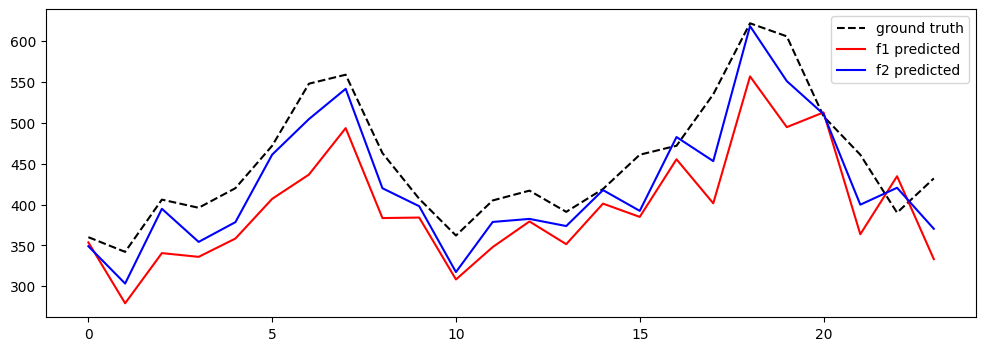

In [498]:
# plot the results
plt.figure(figsize=(12,4))
plt.plot(ground_truth, label='ground truth', color='k', linestyle='--')
plt.plot(f1, label='f1 predicted', color='r')
plt.plot(f2, label='f2 predicted', color='b')

plt.legend()
plt.show()

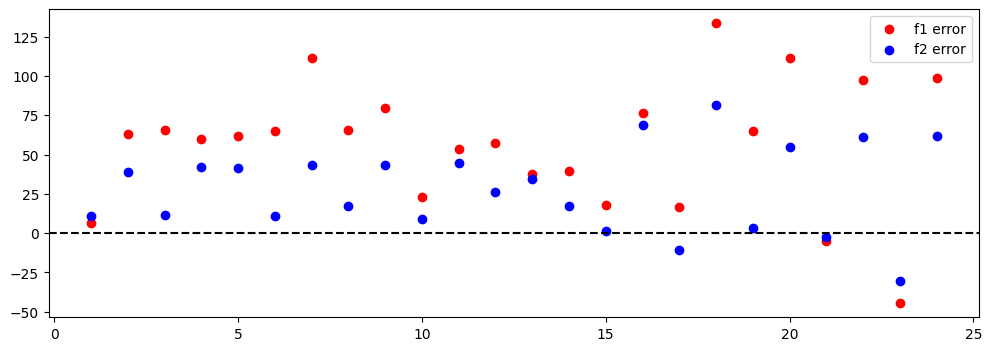

In [499]:
# plot the results
plt.figure(figsize=(12,4))
plt.scatter(np.linspace(1,len(f1_error),len(f1_error)), f1_error, label='f1 error', color='r')
plt.scatter(np.linspace(1,len(f2_error),len(f2_error)), f2_error, label='f2 error', color='b')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.show()

In [500]:
s_1959_01 = ground_truth[0] #
f1_1959_01 = f1[0]
f2_1959_01 = f2[0]
f1 = pd.Series(f1)
f2 = pd.Series(f2)
f1_error = pd.Series(f1_error)
f2_error = pd.Series(f2_error)
print(f"Actual value:{round(s_1959_01,3)}, f1 forecast:{round(f1_1959_01,3)},f2 forecast:{round(f2_1959_01,3)}")
print(f"avg f1:{round(np.array(f1).mean(),4)}, avg f2:{round(np.array(f2).mean(),4)}")
print(f"var of f1:{round(np.array(f1).var(),4)}, var of f2:{round(np.array(f2).var(),4)}")
print(f'mean squared prediction error of f1: {round((f1_error**2).mean(),4)}, mean squared prediction error of f2: {round((f2_error**2).mean(),4)}')

Actual value:360, f1 forecast:353.604,f2 forecast:348.91
avg f1:395.72, avg f2:423.8938
var of f1:4458.1292, var of f2:5773.3767
mean squared prediction error of f1: 4781.9648, mean squared prediction error of f2: 1529.9528


In [501]:
# Joint f-test for model 1
dta = pd.concat([pd.Series(f1,name='f1'), pd.Series(ground_truth,name='s')],axis=1)
dta.columns=['f1','s']
formula = 's ~ f1'
results = sm.OLS.from_formula(formula = formula, data = dta).fit()
hypotheses = '(Intercept = 0), (f1 = 1)'
f_test = results.f_test(hypotheses)
print(f_test)
print(results.params)


<F test: F=22.41800066501185, p=4.915123562479962e-06, df_denom=22, df_num=2>
Intercept    77.290163
f1            0.947538
dtype: float64


In [502]:
# Joint f-test for model 2
dta = pd.concat([pd.Series(f2,name='f2'), pd.Series(ground_truth,name='s')],axis=1)
dta.columns=['f2','s']
formula = 's ~ f2'
results = sm.OLS.from_formula(formula = formula, data = dta).fit()
hypotheses = '(Intercept = 0), (f2 = 1)'
f_test = results.f_test(hypotheses)
print(f_test)
print(results.params)


<F test: F=13.425220883951235, p=0.00015455961894936124, df_denom=22, df_num=2>
Intercept    62.224616
f2            0.920102
dtype: float64


In [505]:
x_i = f1_error + f2_error
z_i = f1_error - f2_error
corr_xz = x_i.corr(z_i,method='pearson')
Granger_Newbold_stats = corr_xz/ np.sqrt( (1-corr_xz**2)/24)
print(Granger_Newbold_stats)


3.7099934537586963


In [463]:
d = np.power(f1_error, 4) - np.power(f2_error, 4)
DM = np.mean(d) / np.power(np.var(d) / (len(d) - 1), 0.5)
print(DM)
acf_d = acf(d, nlags=12)[1:]
print(acf_d)

2.7929590643739144
[-1.73309871e-01  3.49668953e-01 -2.54828373e-01  7.56649460e-02
 -2.04880179e-01 -3.49477760e-04 -1.01014234e-01 -1.06085805e-01
 -6.69912381e-03 -7.74738172e-02  3.13861764e-01 -5.71551707e-02]
